<h2> Estimate the Author-Topic Model </h2>

In [1]:
import gzip
import json
import pickle
import pandas as pd
import numpy as np

from gensim import corpora
from gensim.models import AuthorTopicModel

from tqdm import tqdm

from gensim.matutils import dirichlet_expectation
from gensim.test.utils import datapath
import logging

import re

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["savefig.facecolor"] = "white"

In [2]:
inputs_path = "C:/Users/Hannes/Documents/Joe/TeamsAndText/Inputs"
intermediate_outputs_path = "C:/Users/Hannes/Documents/Joe/TeamsAndText/IntermediateOutputs"
results_path = "C:/Users/Hannes/Documents/Joe/TeamsAndText/Results"

In [3]:
logging.basicConfig(filename=f'{results_path}/atmodel_log.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.INFO)
logging.info('Creating new log file.')

In [4]:
with gzip.open(f"{intermediate_outputs_path}/corpus.json.gz", 'r') as fin:  
    json_bytes = fin.read()                     

json_str = json_bytes.decode('utf-8')            
corpus = json.loads(json_str)  

In [5]:
dictionary = pickle.load(open(f"{intermediate_outputs_path}/id2word.p", "rb")) 
doc2inv = pickle.load(open(f"{intermediate_outputs_path}/doc2inv.p", "rb"))
inv2doc = pickle.load(open(f"{intermediate_outputs_path}/inv2doc.p", "rb"))
print(len(dictionary))

332780


In [6]:
%%time
num_topics = 40
num_iters = 3000
model = AuthorTopicModel(corpus, id2word=dictionary, author2doc=inv2doc, doc2author=doc2inv,
                         num_topics=num_topics, iterations=num_iters, random_state=1234, 
                         alpha=1/num_topics, eta=1/num_topics,
                         gamma_threshold=0.0001, eval_every=1, passes=1) 

Wall time: 2h 20min 15s


In [7]:
temp_file = datapath(f"{intermediate_outputs_path}/model")
model.save(temp_file)

In [8]:
gamma = model.state.gamma
np.save(f"{intermediate_outputs_path}/model.state.gamma.npy", gamma)

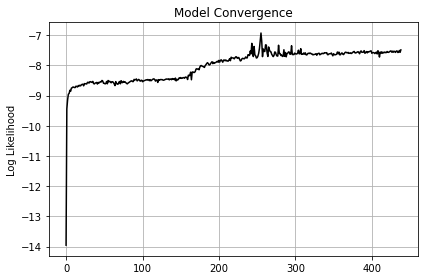

In [16]:
p = re.compile("(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
matches = [p.findall(l) for l in open(f'{results_path}/atmodel_log.log')]
matches = [m for m in matches if len(m) > 0]
tuples = [t[0] for t in matches]
perplexity = [float(t[1]) for t in tuples]
likelihood = [float(t[0]) for t in tuples]
iteration = list(range(len(likelihood)))
plt.plot(iteration, likelihood, c="black")
plt.ylabel("Log Likelihood")
plt.title("Model Convergence")
plt.grid()
plt.tight_layout()
plt.savefig(f"{results_path}/likelihood_convergence.png", dpi=300)
#pickle.dump(liklihood, open(f"{results_path}/likelihood".p", "wb"))

439

In [10]:
inv2id = {inv:id_i for id_i, inv in model.id2author.items()}
author_dists = {author : model.get_author_topics(author) for author in model.id2author.values()}
print(len(author_dists))

549961


In [11]:
author_dists_matched = pd.DataFrame(columns=np.arange(num_topics))
author_dists_matched["inventor_id"] = author_dists.keys()
for num_id, inv_dist in enumerate(tqdm(author_dists.values())):
    for topic, weight in inv_dist:
        author_dists_matched.at[num_id, topic] = weight
author_dists_matched.set_index("inventor_id", inplace=True)
author_dists_matched = author_dists_matched.fillna(0)
author_dists_matched = author_dists_matched.div(author_dists_matched.sum(axis=1), axis=0)
author_dists_matched.head()

100%|████████████████████████████████████████████████████████████████████████| 549961/549961 [01:13<00:00, 7471.15it/s]


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
inventor_id,,,,,,,,,,,,,,,,,,,,,
000f0k6brgval6kr9agzjlgcg,0.016956,0.042798,0.015044,0.013951,0.014559,0.018352,0.023496,0.011593,0.011717,0.018386,...,0.015942,0.021603,0.013660,0.018266,0.015176,0.019915,0.013195,0.066268,0.018848,0.024234
000s9qy0x4l3x4n99bv2a1qn4,0.018542,0.019366,0.022040,0.023650,0.023521,0.027166,0.017240,0.023586,0.055780,0.044352,...,0.026350,0.024584,0.017321,0.026975,0.015852,0.050196,0.015814,0.019539,0.017876,0.022065
003gl0pmpob62w5yf9j8xw1c8,0.012075,0.011243,0.014458,0.000000,0.014285,0.013574,0.127460,0.000000,0.000000,0.022933,...,0.013109,0.075652,0.000000,0.018183,0.000000,0.016722,0.014032,0.026548,0.000000,0.015068
003ibk308p0r5efhppfnkpghy,0.024445,0.020086,0.029494,0.079976,0.019388,0.021980,0.018782,0.018928,0.015187,0.015981,...,0.030111,0.024274,0.021008,0.021286,0.053234,0.020567,0.020010,0.023351,0.023047,0.040818
004sxraydhup13ce43vyj61p1,0.000000,0.000000,0.000000,0.720470,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022669


In [12]:
# Check if these change a lot over different run and parameter values
yes = "fl:jo_ln:olsen-12"
no = "fl:ha_ln:moody-6"
author_dists_matched.loc[yes]

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
24    0.000000
25    0.000000
26    0.000000
27    0.000000
28    0.000000
29    0.000000
30    0.000000
31    0.000000
32    0.000000
33    0.941641
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.058359
Name: fl:jo_ln:olsen-12, dtype: float64

In [13]:
author_dists_matched.loc[no]

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.233885
16    0.000000
17    0.000000
18    0.576842
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
24    0.189273
25    0.000000
26    0.000000
27    0.000000
28    0.000000
29    0.000000
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
Name: fl:ha_ln:moody-6, dtype: float64

In [14]:
center = np.array([1/num_topics]*num_topics)
inventor_distance_center = dict.fromkeys(author_dists_matched.index)
for inv in author_dists_matched.index:
    d_center = np.linalg.norm(author_dists_matched.loc[inv] - center)
    inventor_distance_center[inv] = d_center

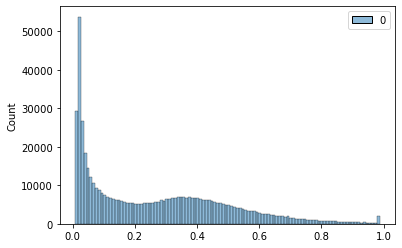

In [15]:
fig, ax = plt.subplots()
sns.histplot(inventor_distance_center.values(), ax=ax)
plt.savefig(f"{results_path}/inventor_distance_hist.png", dpi=300)

In [16]:
topic_distributions = np.transpose(model.get_topics())
topic_distributions = pd.DataFrame(topic_distributions, columns=np.arange(num_topics))
np.shape(topic_distributions)

(332780, 40)

In [17]:
pickle.dump(inv2id, open(f"{intermediate_outputs_path}/inv2id.p", "wb"))
topic_distributions.to_csv(f"{results_path}/topic_distributions.csv")
author_dists_matched.to_csv(f"{results_path}/inventor_distributions.csv")

In [18]:
len(corpus)

876535